<a href="https://colab.research.google.com/github/hongqin/Generative_AI_Fa25/blob/main/Positional_Encoding_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Positional Encoding Comparison ---
L=32, D=128, D_K=64. Query position fixed at 4.

1. Sinusoidal PE Matrix: (32, 128) (L x D)
2. RoPE Rotation Terms: (32, 32) (L x Dk/2)
3. ALiBi Bias Matrix (Head 3): (32, 32) (L x L), Slope=0.0625
4. Rotary Fourier Features: (32, 128) (L x D)


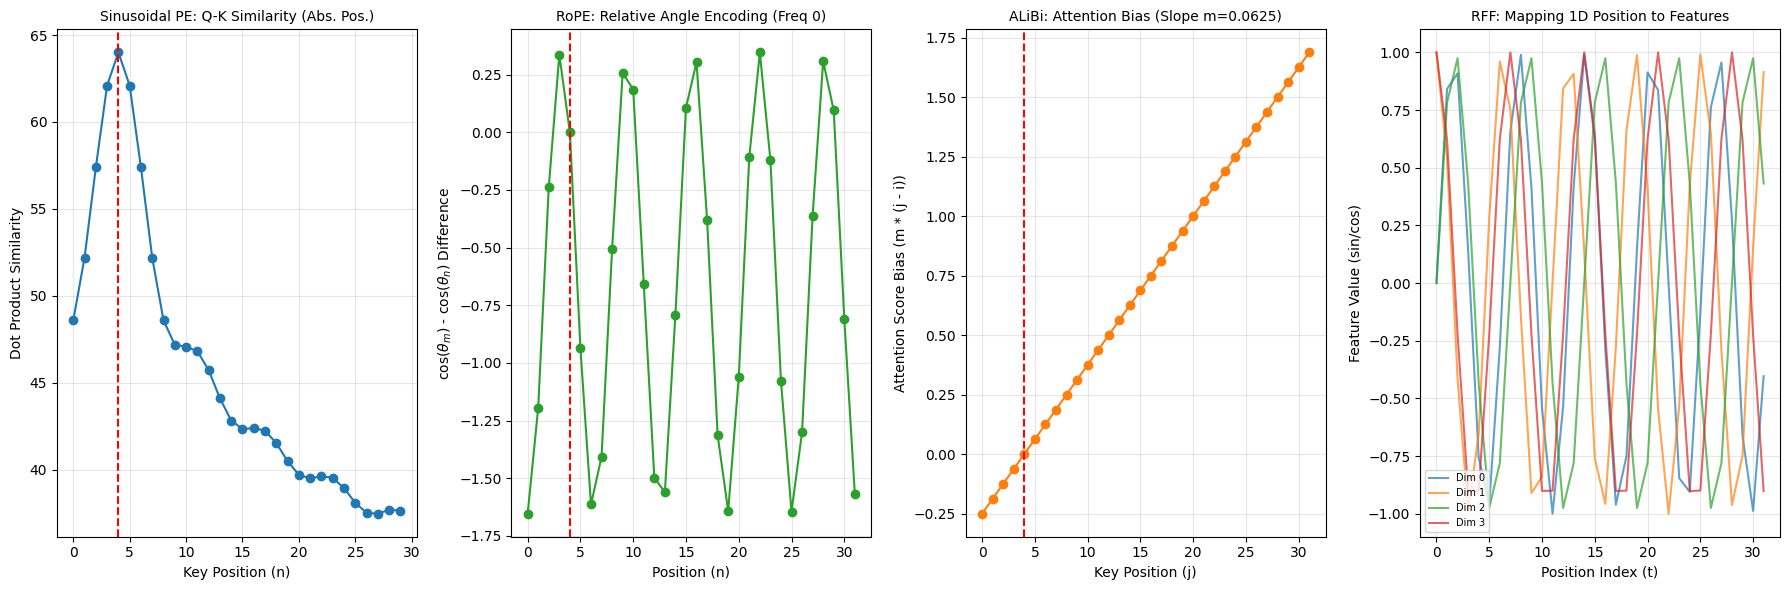

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Configuration ---
# Sequence length (L): The maximum length of the input sequence.
SEQ_LEN = 32
# Embedding dimension (d): The dimensionality of the model's embeddings.
D_MODEL = 128
# Head dimension (d_k): The dimensionality of a single attention head.
D_HEAD = 64
# Max distance to plot: Limits the range of relative distances shown in some plots.
MAX_RELATIVE_DISTANCE = 15

# --- 1. Sinusoidal Position Encoding (Absolute PE) ---
# Used in the original Transformer paper. The PE is added directly to the input embeddings.
def get_sinusoidal_pe(seq_len: int, d_model: int) -> np.ndarray:
    """Generates the Sinusoidal PE matrix (L x D_MODEL)."""
    # Initialize a matrix of zeros for positional encodings (L x D_MODEL).
    pe = np.zeros((seq_len, d_model))
    # Create a column vector for positions (0, 1, ..., L-1).
    position = np.arange(seq_len)[:, np.newaxis]
    # Calculate the `div_term` as 1 / (10000^(2i/d_model)). This creates a range of frequencies.
    div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

    # Apply sine to even indices of the embedding.
    pe[:, 0::2] = np.sin(position * div_term)
    # Apply cosine to odd indices of the embedding.
    pe[:, 1::2] = np.cos(position * div_term)

    return pe

# --- 2. Rotary Position Embedding (RoPE) ---
# Used in models like LLaMA and PaLM. The PE is applied as a rotation to Q and K vectors.
def get_rope_matrix(seq_len: int, d_head: int, base: float = 10000.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates the rotation terms for RoPE. The dot-product attention
    becomes explicitly dependent on relative distance (m - n).
    """
    # 1. Calculate the rotation frequencies (theta_i)
    # Generate indices for even dimensions (0, 2, 4, ...).
    indices = np.arange(0, d_head, 2)
    # Calculate inverse frequencies based on the base and head dimension.
    # This creates a set of frequencies for rotation.
    inv_freq = 1.0 / (base ** (indices / d_head)) # (d_head/2, )

    # 2. Calculate the position indices (m)
    # Create a vector of position indices (0, 1, ..., L-1).
    t = np.arange(seq_len) # (L, )

    # 3. Calculate theta_m = t_m * inv_freq
    # Outer product combines positions with inverse frequencies to get rotation angles.
    freqs = np.outer(t, inv_freq) # (L, d_head/2)

    # 4. Compute the rotation angles (theta_m)
    # Calculate cosine and sine components of the rotation angles.
    cos_terms = np.cos(freqs)  # (L, d_head/2)
    sin_terms = np.sin(freqs)  # (L, d_head/2)

    return cos_terms, sin_terms

# --- 3. Attention with Linear Biases (ALiBi) ---
# Used in models like Bloom. It adds a constant penalty bias to the attention scores.
def get_alibi_bias(seq_len: int, num_heads: int, head_index: int, slope_power: float = 2**(-8)) -> np.ndarray:
    """
    Generates the ALiBi bias matrix (L x L) for a single head.
    The bias matrix M is defined as: M[i, j] = m * (j - i)
    where m is the head-specific slope.
    """
    # Define the total number of attention heads for slope calculation.
    NUM_HEADS = num_heads
    # Calculate head-specific slopes according to the ALiBi paper formula.
    slopes = np.power(slope_power, (np.arange(1, NUM_HEADS + 1) * (1/NUM_HEADS)))
    # Select the slope for the current head_index.
    m = slopes[head_index]

    # Create the query position indices (i).
    i = np.arange(seq_len)[:, np.newaxis] # Query positions
    # Create the key position indices (j).
    j = np.arange(seq_len)                # Key positions
    # Calculate the relative distance matrix (key position - query position).
    distance_matrix = j - i               # (L x L), relative distance (key pos - query pos)

    # Apply the head-specific slope to the distance matrix to get the ALiBi bias.
    alibi_matrix = m * distance_matrix
    return alibi_matrix, m

# --- 4. Rotary Fourier Features (RFF) ---
# Used primarily in Neural Fields (like NeRF) to map 1D or ND coordinates into a high-frequency space.
def get_rff_features(seq_len: int, d_model: int, scale: float = 1000.0) -> np.ndarray:
    """
    Generates Fourier Features for position indices.
    It maps the 1D position index (t) into a high-dimensional feature vector,
    making it easier for an MLP to learn high-frequency details.
    """
    # Create a column vector for position indices (0, 1, ..., L-1).
    t = np.arange(seq_len)[:, np.newaxis] # Position indices (L x 1)

    # Determine the number of unique frequencies needed (half of d_model).
    num_frequencies = d_model // 2
    # Calculate logarithmically spaced frequency scales. The 'scale' parameter controls the highest frequency.
    freq_scale = 1.0 / (scale ** (np.arange(num_frequencies) / num_frequencies))

    # Calculate the phase: position * frequency_scale.
    theta = t * freq_scale

    # Initialize a matrix of zeros for RFF features.
    rff = np.zeros((seq_len, d_model))
    # Apply sine to even dimensions of the RFF features.
    rff[:, 0::2] = np.sin(theta)
    # Apply cosine to odd dimensions of the RFF features.
    rff[:, 1::2] = np.cos(theta)

    return rff

# --- 5. Comparison and Visualization ---
def run_comparison():
    # Print a header for the comparison section.
    print(f"--- Positional Encoding Comparison ---")
    # Fixed query position for relative comparison plots.
    fixed_pos = 4
    # Print configuration details and the chosen fixed query position.
    print(f"L={SEQ_LEN}, D={D_MODEL}, D_K={D_HEAD}. Query position fixed at {fixed_pos}.")


    # --- Sinusoidal PE Demo ---
    # Generate Sinusoidal Positional Embeddings.
    pe_sin = get_sinusoidal_pe(SEQ_LEN, D_MODEL)
    # Print the shape of the generated Sinusoidal PE matrix.
    print(f"\n1. Sinusoidal PE Matrix: {pe_sin.shape} (L x D)")

    # Sinusoidal Visualization Data
    # Calculate the dot product between the PE at fixed_pos and all other PEs.
    # This approximates similarity and shows how it changes with distance.
    similarity = np.dot(pe_sin[fixed_pos, :], pe_sin.T)

    # --- RoPE Demo ---
    # Generate RoPE rotation terms (cosine and sine components).
    cos_terms, sin_terms = get_rope_matrix(SEQ_LEN, D_HEAD)
    # Print the shape of the RoPE rotation terms.
    print(f"2. RoPE Rotation Terms: {cos_terms.shape} (L x Dk/2)")

    # RoPE Visualization Data
    # Select the first frequency index for visualization.
    first_freq_index = 0
    # Calculate the difference in cosine terms at the fixed query position and all other positions.
    # This illustrates how RoPE encodes relative distance via phase differences.
    rope_relative_angle = cos_terms[fixed_pos, first_freq_index] - cos_terms[:, first_freq_index]

    # --- ALiBi Demo ---
    # Define the number of heads for ALiBi.
    NUM_HEADS = 8
    # Generate the ALiBi bias matrix for a specific head index.
    alibi_bias_matrix, slope_m = get_alibi_bias(SEQ_LEN, NUM_HEADS, head_index=3)
    # Print the shape of the ALiBi bias matrix and its slope.
    print(f"3. ALiBi Bias Matrix (Head 3): {alibi_bias_matrix.shape} (L x L), Slope={slope_m:.4f}")

    # ALiBi Visualization Data
    # Extract the row corresponding to the fixed query position from the bias matrix.
    # This shows how the bias is applied for a query at 'fixed_pos'.
    alibi_bias_row = alibi_bias_matrix[fixed_pos, :]

    # --- RFF Demo ---
    # Generate Rotary Fourier Features.
    rff_features = get_rff_features(SEQ_LEN, D_MODEL)
    # Print the shape of the RFF features matrix.
    print(f"4. Rotary Fourier Features: {rff_features.shape} (L x D)")

    # RFF Visualization Data: Plot the first 4 feature dimensions across the sequence
    # Select a subset of dimensions for plotting to show feature variation.
    rff_dim_subset = rff_features[:, :4]


    # --- Plotting the Relative Distance Modeling ---
    # Create a figure to hold multiple subplots.
    plt.figure(figsize=(18, 6))
    # Create an array of positions for x-axis labels.
    positions = np.arange(SEQ_LEN)

    # Plot 1: Sinusoidal PE Dot Product
    # Create the first subplot.
    plt.subplot(1, 4, 1)
    # Plot the similarity values against key positions.
    plt.plot(positions[:MAX_RELATIVE_DISTANCE*2], similarity[:MAX_RELATIVE_DISTANCE*2], marker='o', linestyle='-', color='tab:blue')
    # Set the title for the subplot.
    plt.title('Sinusoidal PE: Q-K Similarity (Abs. Pos.)', fontsize=10)
    # Set x-axis label.
    plt.xlabel('Key Position (n)')
    # Set y-axis label.
    plt.ylabel('Dot Product Similarity')
    # Add a vertical line at the fixed query position for reference.
    plt.axvline(fixed_pos, color='r', linestyle='--', label=f'Query Pos {fixed_pos}')
    # Add a grid for better readability.
    plt.grid(True, alpha=0.3)

    # Plot 2: RoPE Phase Difference
    # Create the second subplot.
    plt.subplot(1, 4, 2)
    # Plot the relative angle encoding for RoPE.
    plt.plot(positions, rope_relative_angle, marker='o', linestyle='-', color='tab:green')
    # Set the title for the subplot.
    plt.title('RoPE: Relative Angle Encoding (Freq 0)', fontsize=10)
    # Set x-axis label.
    plt.xlabel('Position (n)')
    # Set y-axis label.
    plt.ylabel(r'cos($\theta_m$) - cos($\theta_n$) Difference')
    # Add a vertical line at the fixed query position for reference.
    plt.axvline(fixed_pos, color='r', linestyle='--', label=f'Query Pos {fixed_pos}')
    # Add a grid for better readability.
    plt.grid(True, alpha=0.3)

    # Plot 3: ALiBi Bias
    # Create the third subplot.
    plt.subplot(1, 4, 3)
    # Plot the ALiBi bias values for the fixed query position.
    plt.plot(positions, alibi_bias_row, marker='o', linestyle='-', color='tab:orange')
    # Set the title for the subplot, including the calculated slope.
    plt.title(f'ALiBi: Attention Bias (Slope m={slope_m:.4f})', fontsize=10)
    # Set x-axis label.
    plt.xlabel('Key Position (j)')
    # Set y-axis label, explaining the bias formula.
    plt.ylabel('Attention Score Bias (m * (j - i))')
    # Add a vertical line at the fixed query position for reference.
    plt.axvline(fixed_pos, color='r', linestyle='--', label=f'Query Pos {fixed_pos}')
    # Add a grid for better readability.
    plt.grid(True, alpha=0.3)

    # Plot 4: Rotary Fourier Features (RFF)
    # Create the fourth subplot.
    plt.subplot(1, 4, 4)
    # Iterate and plot a subset of RFF dimensions to show their high-frequency nature.
    for i in range(rff_dim_subset.shape[1]):
        # Plot the first 4 feature dimensions to show the high-frequency mapping
        plt.plot(positions, rff_dim_subset[:, i], linestyle='-', alpha=0.7, label=f'Dim {i}')
    # Set the title for the subplot.
    plt.title('RFF: Mapping 1D Position to Features', fontsize=10)
    # Set x-axis label.
    plt.xlabel('Position Index (t)')
    # Set y-axis label.
    plt.ylabel('Feature Value (sin/cos)')
    # Add a legend to distinguish the different feature dimensions.
    plt.legend(loc='lower left', fontsize=7)
    # Add a grid for better readability.
    plt.grid(True, alpha=0.3)

    # Adjust subplot parameters for a tight layout.
    plt.tight_layout()
    # Display the generated plots.
    plt.show()

# Run the demonstration if this script is executed directly.
if __name__ == "__main__":
    run_comparison()

# Note on other methods:
# This section provides additional context on other related positional encoding methods not fully implemented in this demo.
# - Rotary Fourier Features (RFF): Shown here. They map coordinates to a dense, high-frequency embedding, primarily for Neural Fields/MLPs.
# - XPos / YaRN: Extensions of RoPE designed for length extrapolation by modifying the magnitude and frequency base, respectively.
# - Performer-RoPE hybrid: Combines RoPE with the Performer's linear attention mechanism.
# - Neural-Field encodings (SIREN): Uses a Sinusoidal Activation Network (SIN) as the PE, effectively learning the encoding.